In [76]:
import jax
import jax.numpy as jnp
import jax.scipy.special
import dataclasses
from dataclasses import replace
from functools import partial

import subprocess
import os
import h5py

import vtk
from vtk.util import numpy_support

import jaxdem as jd

import pydpmd as dp
from pydpmd.utils import split_systems

jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

In [245]:
path = '/home/mmccraw/dev/data/11-15-25/jamming/rb/mu-1.0-nv-31/jamming_9'
# path = '/home/mmccraw/dev/data/11-06-25/jamming/N-100/31-1.00/jamming_2'
# path = '/home/mmccraw/dev/data/11-15-25/jamming/disk/jamming_9'
data = dp.data.load(path, location=['final'])

data.calculate_packing_fraction()
data.scale_to_packing_fraction(data.packing_fraction - 2e-1)
data.set_velocities(1e-4, np.random.randint(0, 1e9))

r_world = data.vertex_pos - data.pos[data.vertex_particle_id]
theta = data.angle[data.vertex_particle_id]

c, s = np.cos(theta), np.sin(theta)
pos_p = np.stack([c * r_world[:, 0] - s * r_world[:, 1], s * r_world[:, 0] + c * r_world[:, 1]], axis=-1)


np.savez(
    'clump.npz',
    pos_p=pos_p,
    pos_c=data.pos[data.vertex_particle_id],
    rad=data.vertex_rad,
    vel=data.vel[data.vertex_particle_id],
    angVel=data.angular_vel[data.vertex_particle_id][:, None],
    angle=theta,
    mass=data.mass[data.vertex_particle_id],
    inertia=data.moment_inertia[data.vertex_particle_id][:, None],
    ID=data.vertex_particle_id,
    box_size=data.box_size[0],
)

In [223]:
# TODO: may want to add some flexibility for setting 2d angles, angular velocities, and inertia
# based on (N,) shaped arrays rather than forcing (N, 1) shaped arrays

# how to set the quarternion based on the angle?

def build_state_from_data(data, temp, dt):
    data.set_velocities(temp, np.random.randint(0, 1e9))
    mats = [jd.Material.create("elastic", young=data.e_interaction[0], poisson=0.5, density=1.0)]
    matcher = jd.MaterialMatchmaker.create("harmonic")
    mat_table = jd.MaterialTable.from_materials(mats, matcher=matcher)

    w = jnp.full((data.n_vertices(), 1), jnp.cos(data.angle[data.vertex_particle_id][:, None] / 2.0))
    xyz = jnp.zeros((data.n_vertices(), 3))
    xyz = xyz.at[:, 2].set(jnp.sin(data.angle[data.vertex_particle_id] / 2.0))
    q = jd.utils.Quaternion.create(w=w, xyz=xyz)

    state = jd.State.create(
        pos=data.vertex_pos,
        vel=data.vel[data.vertex_particle_id],
        # q=q,
        angVel=data.angular_vel[data.vertex_particle_id][:, None],
        rad=data.vertex_rad,
        mass=data.mass[data.vertex_particle_id],
        inertia=data.moment_inertia[data.vertex_particle_id][:, None],
        ID=data.vertex_particle_id,
        # volume=data.area
    )

    state = jd.utils.compute_clump_properties(state, mat_table)

    system = jd.System.create(
        state_shape=state.shape,
        dt=dt,
        linear_integrator_type="verlet",
        # rotation_integrator_type="spiral",
        rotation_integrator_type="",  # to turn rotations off
        domain_type="periodic",
        force_model_type="spring",
        collider_type="naive",
        mat_table=mat_table,
        domain_kw=dict(
            box_size=data.box_size[0],
        ),
    )
    return system, state

In [224]:
path = '/home/mmccraw/dev/data/11-15-25/jamming/rb/mu-1.0-nv-31/jamming_9'
# path = '/home/mmccraw/dev/data/11-06-25/jamming/N-100/31-1.00/jamming_2'
# path = '/home/mmccraw/dev/data/11-15-25/jamming/disk/jamming_9'
data = dp.data.load(path, location=['final'])

count = 0

dt = 1e-2
temp = 1e-4

states, systems = [], []
for d in split_systems(data):
    d.calculate_packing_fraction()
    d.scale_to_packing_fraction(d.packing_fraction - 2e-1)
    system, state = build_state_from_data(d, temp, dt)
    systems.append(system)
    states.append(state)
    
    count += 1
    if count > 1:
        break

# state = jd.State.stack(states)
# system = jd.System.stack(systems)


In [225]:
n_repeats = 100
ke = np.zeros(n_repeats)
pe = np.zeros(n_repeats)
particle_offset = jnp.concatenate((jnp.zeros(1), jnp.cumsum(jnp.bincount(state.ID)))).astype(jnp.int32)
for i in range(n_repeats):
    n_steps = 100
    state, system = system.step(state, system, n=n_steps)
    ke_t = 0.5 * (state.mass * jnp.sum(state.vel ** 2, axis=-1))
    ke_r = 0.5 * (state.inertia * state.angVel ** 2).squeeze()
    ke[i] = jnp.sum((ke_t + ke_r)[particle_offset])
    pe[i] = jnp.sum(system.collider.compute_potential_energy(state, system))

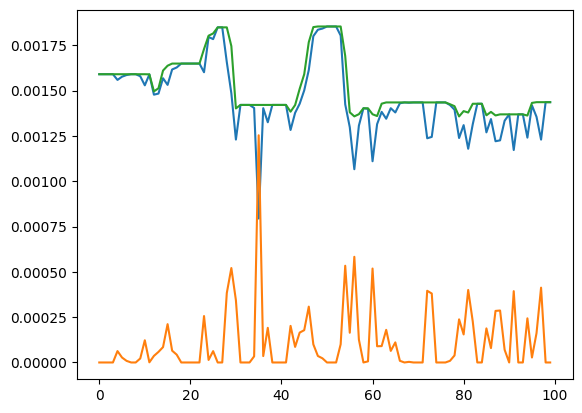

In [226]:
plt.plot(ke)
plt.plot(pe)
plt.plot(ke + pe / 2)

In [ ]:
n_steps = 10000
save_stride = 10
n_snapshots = n_steps // save_stride

final_state, final_system, (traj_state, traj_system) = jd.System.trajectory_rollout(
    state, system, n=n_snapshots, stride=save_stride
)

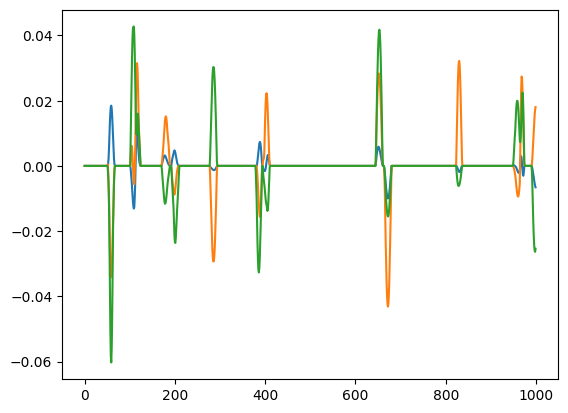

In [164]:
plt.plot(traj_state.torque[:, 0])
plt.plot(traj_state.force[:, 20])

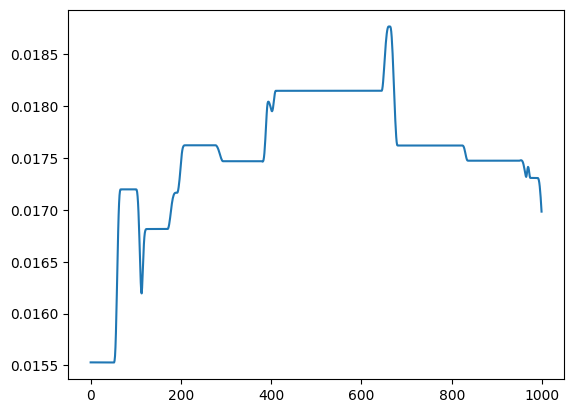

In [166]:
# plt.plot(traj_state.pos[:, 0])
plt.plot(traj_state.angVel[:, 0])
# plt.plot(traj_state.q.w[:, 0])

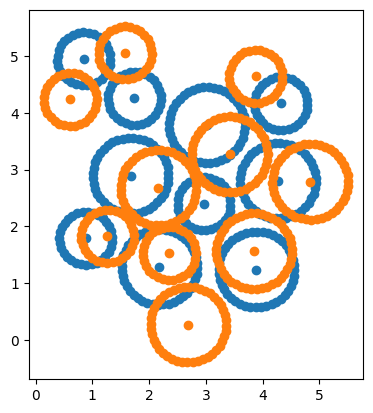

In [167]:
plt.scatter(*traj_state.pos[0].T)
plt.scatter(*traj_state.pos[-1].T)
plt.gca().set_aspect("equal")

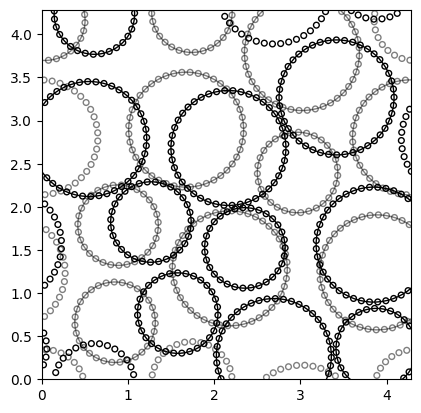

In [168]:
def draw_frame(traj_state, traj_system, frame, ax=None, fig=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_aspect("equal")
    bs = traj_system.domain.box_size[frame]
    ax.set_xlim(0, bs[0])
    ax.set_ylim(0, bs[1])
    pos = jnp.mod(traj_state.pos[frame], bs)
    rad = traj_state.rad[frame]
    for p, r in zip(pos, rad):
        c = Circle(p, r, fill=False, **kwargs)
        ax.add_artist(c)
    return fig, ax

fig, ax = draw_frame(traj_state, traj_system, 0, alpha=0.5)
fig, ax = draw_frame(traj_state, traj_system, 1000, ax=ax, fig=fig)

In [169]:
from matplotlib import animation


def draw_frame(traj_state, traj_system, frame, ax=None, fig=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_aspect("equal")
    bs = traj_system.domain.box_size[frame]
    ax.set_xlim(0, bs[0])
    ax.set_ylim(0, bs[1])
    pos = jnp.mod(traj_state.pos[frame], bs)
    rad = traj_state.rad[frame]
    for p, r in zip(pos, rad):
        c = Circle(p, r, fill=False, **kwargs)
        ax.add_artist(c)
    return fig, ax


def animate_trajectory(traj_state, traj_system, N_frames=200, interval=50, save_path="traj.gif", **kwargs):
    """Animate the trajectory using at most N_frames, evenly sampled if needed, and save as a GIF."""
    n_traj_frames = traj_state.pos.shape[0]

    if n_traj_frames <= N_frames:
        frame_indices = np.arange(n_traj_frames)
    else:
        frame_indices = np.linspace(0, n_traj_frames - 1, N_frames, dtype=int)
        frame_indices = np.unique(frame_indices)

    fig, ax = plt.subplots()

    def update(i):
        ax.clear()
        frame = frame_indices[i]
        draw_frame(traj_state, traj_system, frame, ax=ax, fig=fig, **kwargs)
        return ax.artists

    anim = animation.FuncAnimation(
        fig,
        update,
        frames=len(frame_indices),
        interval=50,
        blit=False,
    )

    # Save as GIF using Pillow writer
    writer = animation.PillowWriter(fps=1000 / 50)
    anim.save(save_path, writer=writer)
    plt.close(fig)

    return save_path


N_frames = 50  # maximum number of frames to use in the animation
gif_path = animate_trajectory(traj_state, traj_system, N_frames=N_frames, alpha=0.5)
gif_path

'traj.gif'